# 18/12/2019 -- SVC 

In [252]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kurtosis,skew

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import make_scorer
from tqdm import tqdm_notebook as tqdm
import pyeeg

import yasa

# Load Data

In [253]:
xtrain_eeg1 = pd.read_csv("train_eeg1.csv").drop("Id", axis = 1)
xtrain_eeg2 = pd.read_csv("train_eeg2.csv").drop("Id", axis = 1)
xtrain_emg = pd.read_csv("train_emg.csv").drop("Id", axis = 1)

ytrain = pd.read_csv("train_labels.csv").drop("Id", axis = 1)

xtest_eeg1 = pd.read_csv("test_eeg1.csv").drop("Id", axis = 1)
xtest_eeg2 = pd.read_csv("test_eeg2.csv").drop("Id", axis = 1)
xtest_emg = pd.read_csv("test_emg.csv").drop("Id", axis = 1)

In [254]:
print(xtrain_eeg1.shape)
print(xtrain_eeg2.shape)
print(xtrain_emg.shape)
print(xtest_eeg1.shape)
print(xtest_eeg2.shape)
print(xtest_emg.shape)
print(ytrain.shape)

(64800, 512)
(64800, 512)
(64800, 512)
(43200, 512)
(43200, 512)
(43200, 512)
(64800, 1)


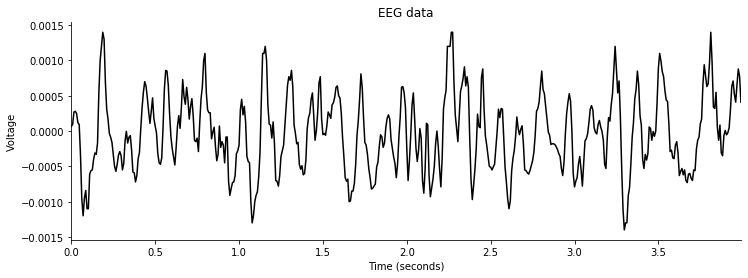

In [255]:
signal = xtrain_eeg1.iloc[1,:].values
# Define sampling frequency and time vector
sf = 128
time = np.arange(signal.size) / sf

# Plot the signal
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(time, signal, lw=1.5, color='k')
plt.xlabel('Time (seconds)')
plt.ylabel('Voltage')
plt.xlim([time.min(), time.max()])
plt.title('EEG data')
sns.despine()

# Functions for Feature Extraction

In [301]:
K_boundary = 10        # to be tuned
t_fisher = 12          # to be tuned
d_fisher = 40          # to be tuned
threshold =  0.00055

###############################################################################
###############################################################################
'''  ## PRELIMINARY FUNCTIONS ##   '''
###############################################################################
###############################################################################
def MAXX(array): 
    if len(array) > 0: 
        maxx = np.max(array)
    else: 
        maxx = threshold
    return maxx   


def MINN(array):
    if len(array) > 0: 
        minn = np.min(array)
    else: 
        minn = threshold
    return minn
        
    
def fisher_info(signal, t_fisher = 12, d_fisher = 40):
    info = pyeeg.fisher_info(signal, t_fisher, d_fisher)
    return info

def petro_frac_dim(signal):
    petro = pyeeg.pfd(signal)
    return petro

def detrended_fluc_anal(signal):
    detr_analysis = pyeeg.dfa(signal)
    return(detr_analysis)

def higuchi_frac_dim(signal, K = K_boundary): 
    higu_frac = pyeeg.hfd(signal, K)
    return higu_frac

def sum_abs_transform(signal): 
    sum_abs = np.sum((abs(signal) ** (-0.3)) > 20) 
    return sum_abs

def sum_abs_threshold(signal): 
    sum_threshold = np.sum((abs(signal)) > threshold)
    return sum_abs_threshold

def std_abs(signal): 
    std_abs = np.std(abs(signal) ** (0.05))
    return std_abs

###############################################################################
###############################################################################
'''  ## EEG FEATURES ##   '''
###############################################################################
###############################################################################

'''NOTE TO SELF: remember to chance features_num_{eeg, emg} whenever playing around with features'''
'''extracting bandpower from eeg signal'''

# Note that yasa's bandpower function limits the row length to the amount of columns divided by 2
# Therefore, iterate in for loop 100 rows at a time

def extract_bandpower_eeg(signal, frequency = 128):
    for i in (np.arange(signal.shape[0] / 100) + 1):
        if i == 1:
            df = yasa.bandpower(signal.iloc[0:int(100*i),:].values, sf=frequency)
        else:
            df = df.append(yasa.bandpower(signal.iloc[int(100*(i-1)):int(100*i),:].values, sf=frequency))
    
    df = df.set_index(np.arange(signal.shape[0]))
    df = df.drop(columns = ["FreqRes","Relative"], axis = 1)
    return df

###############################################################################

'''extracting descriptive statistics for eeg signals'''
    
def descriptive_statistics_EEG(signal, fs = 128):
       
    features_num_eeg = 15

    '''simple statistics'''
    """ TESTED for (nxd) matrix input """
    # Check if it is not a 1d array
    if (len(signal.shape) > 1) and (signal.shape[1]!=1):
        simple_stats = np.array([np.mean(signal, axis=1), 
                        np.median(signal, axis=1),
                        np.std(signal, axis=1), 
                        np.max(signal, axis=1),
                        np.min(signal, axis=1), 
                        kurtosis(signal, axis=1),
                        skew(signal, axis=1), 
                        np.sum(np.abs(signal), axis = 1)]).T
                        
    else:
        print("Not Tested with this input!")
        simple_stats =  np.array([np.mean(signal), 
                        np.median(signal), 
                        np.std(sigal),
                        np.max(signal), 
                        np.min(signal), 
                        float(kurtosis(signal)),
                        float(skew(signal))])
        
        ########################################################à

    
    advanced_stats = np.zeros((signal.shape[0],features_num_eeg))
    for i in tqdm((np.arange(signal.shape[0]))):
        feat_array = np.array([
                       pyeeg.fisher_info(signal.iloc[i,:], t_fisher, d_fisher), 
                       pyeeg.pfd(signal.iloc[i,:]), 
                       #pyeeg.dfa(signal.iloc[i,:]),
                       #pyeeg.hfd(signal.iloc[i,:], K_boundary),
                       np.sum((abs(signal.iloc[i,:]) ** (-0.3)).values > 20),
                       np.sum((abs(signal.iloc[i,:])).values > threshold),
                       np.std(abs(signal.iloc[i,:].values) ** (0.05)), 
                       # std of peak locations   
                       np.std(np.argwhere(signal.iloc[i,:] > threshold)),
                       # std of first differences of peak locations
                       np.std(np.diff(np.argwhere(signal.iloc[i,:] > threshold), axis = 0)),
                       # sum of first differences  
                       np.sum(np.diff(np.argwhere(signal.iloc[i,:] > threshold), axis = 0)),
                       # median of location of peaks 
                       np.median(np.argwhere(signal.iloc[i,:] > threshold)),
                       #median of first differences
                       np.median(np.diff(np.argwhere(signal.iloc[i,:] > threshold), axis = 0)),
                       # median of peak values
                       np.median(np.array(signal.iloc[i,:])[np.argwhere(signal.iloc[i,:] > threshold)]),
                       # stds of peak values
                       np.std(np.array(signal.iloc[i,:])[np.argwhere(signal.iloc[i,:] > threshold)]),
                       # max of peak values (if array is non-empty)
                       MAXX(np.array(signal.iloc[i,:])[np.argwhere(signal.iloc[i,:] > threshold)]),
                       # min of peak values (if array is non-empty)
                       MINN(np.array(signal.iloc[i,:])[np.argwhere(signal.iloc[i,:] > threshold)]),
                       #standard deviation of first differences of peak values
                       np.std(np.diff(np.array(signal.iloc[i,:])[np.argwhere(signal.iloc[i,:] > threshold)], axis = 0))
                              ])
        
        advanced_stats[i,:] = feat_array
    
    union_smpl_adv = np.concatenate((simple_stats, advanced_stats), axis = 1)
    return (union_smpl_adv)
    
'''print('advanced stats...')
advanced_stats = np.array([
                        np.apply_along_axis(fisher_info, 1, signal), 
                        np.apply_along_axis(petro_frac_dim, 1, signal), 
                        #np.apply_along_axis(detrended_fluc_anal, 1, xtrain_eeg1),
                        #np.apply_along_axis(higuchi_frac_dim, 1, xtrain_eeg1), 
                        np.apply_along_axis(sum_abs_transform, 1, signal), 
                        np.apply_along_axis(sum_abs_threshold, 1, signal), 
                        np.apply_along_axis(std_abs, 1, signal)
                        ]).T'''

###############################################################################

'''joining bandpower and descriptive statistics'''

def EEG_feature_extraction(signal, fs = 128): 
    eeg_features = np.concatenate((extract_bandpower_eeg(signal, 128), descriptive_statistics_EEG(signal, fs = 128)), axis = 1)
    
    return(eeg_features)

###############################################################################
###############################################################################
'''  ## EMG FEATURES ##   '''
###############################################################################
###############################################################################

'''extracting descriptive statistics for emg signals'''

def EMG_feature_extraction(signal, fs = 128):
    features_num_emg = 6
    
    '''simple statistics'''
    """ TESTED for (nxd) matrix input """
    # Check if it is not a 1d array
    if (len(signal.shape) > 1) and (signal.shape[1]!=1):
        simple_stats = np.array([np.mean(signal, axis=1), 
                        np.median(signal, axis=1),
                        np.std(signal, axis=1), 
                        np.max(signal, axis=1),
                        np.min(signal, axis=1), 
                        kurtosis(signal, axis=1),
                        skew(signal, axis=1), 
                        pd.Series(np.sum(np.abs(signal), axis = 1))]).T
                        
    else:
        print("Not Tested with this input!")
        simple_stats =  np.array([np.mean(signal), 
                        np.median(signal), 
                        np.std(sigal),
                        np.max(signal), 
                        np.min(signal), 
                        float(kurtosis(signal)),
                        float(skew(signal))])

    advanced_stats = np.zeros((signal.shape[0],features_num_emg))
    for i in tqdm((np.arange(signal.shape[0]))):
        feat_array = np.array([
                              np.median(signal.iloc[i,:] ** 2), 
                              #np.median(signal.iloc[i,:] ** 3), 
                              np.median(np.abs(np.diff(signal.iloc[i,:]))), 
                              np.std(np.abs(np.diff(signal.iloc[i,:]))), 
                              np.sum(np.abs(np.diff(signal.iloc[i,:]))), 
                              np.mean(np.power(np.diff(signal.iloc[i,:]), 2)),
                              np.std(abs(signal.iloc[i,:].values))
                            ])

        advanced_stats[i, :] = feat_array 
        
        union_smpl_adv = np.concatenate((simple_stats, advanced_stats), axis = 1)

    return(union_smpl_adv)


# Feature Extraction

In [129]:
'''added to conduct some experiments  --- training of 1st subj and testing on 2nd subj'''
'''create training data'''

subj1_eeg1 = xtrain_eeg1.iloc[0:21599,:]
subj1_eeg2 = xtrain_eeg2.iloc[0:21599,:]
subj1_emg = xtrain_emg.iloc[0:21599,:]
ytrain_subj1 = ytrain.iloc[0:21599,:]

xtrain_subj1_eeg_1 = EEG_feature_extraction(subj1_eeg1, 128)  
xtrain_subj1_eeg_2 = EEG_feature_extraction(subj1_eeg2, 128)
xtrain_subj1_emg = EMG_feature_extraction(subj1_emg, 128)
xtrain_subj1 = np.concatenate((xtrain_subj1_eeg_1, xtrain_subj1_eeg_2, xtrain_subj1_emg), axis = 1)

#print(xtrain_subj1_eeg_1.shape, xtrain_subj1_eeg_2.shape, xtrain_subj1_emg)
#print(xtrain_subj1.shape)

'''creating test data'''

subj2_eeg1 = xtrain_eeg1.iloc[21600:43199,:]
subj2_eeg2 = xtrain_eeg2.iloc[21600:43199,:]
subj2_emg = xtrain_emg.iloc[21600:43199,:]
ytest_subj2 = ytrain.iloc[21600:43199,:]

xtest_subj2_eeg_1 = EEG_feature_extraction(subj2_eeg1, 128)
xtest_subj2_eeg_2 = EEG_feature_extraction(subj2_eeg2, 128)
xtest_subj2_emg = EMG_feature_extraction(subj2_emg, 128)
xtest_subj2 = np.concatenate((xtest_subj2_eeg_1, xtest_subj2_eeg_2, xtest_subj2_emg), axis = 1)

SyntaxError: invalid syntax (<ipython-input-129-43760e09d13f>, line 1)

# Experiments on Features

In [253]:
from sklearn import svm
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.metrics import balanced_accuracy_score

clf = svm.SVC(kernel='rbf', C = 0.3, gamma = 'auto', class_weight = 'balanced')
scaler = preprocessing.StandardScaler()

xtrain_subj1_rescaled = scaler.fit_transform(xtrain_subj1)
xtest_subj2 = scaler.fit_transform(xtest_subj2)

print('fitting model')
clf.fit(xtrain_subj1_rescaled, ytrain_subj1)
print('making predictions')
ypred = clf.predict(xtest_subj2)

BMAC = balanced_accuracy_score(ytest_subj2, ypred)

print(BMAC)

C:\Users\Nicolò Grometto\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:747: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\Nicolò Grometto\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:688: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)
C:\Users\Nicolò Grometto\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:747: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\Nicolò Grometto\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:688: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)


fitting model


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

# Experiments for Submission -- IGNORE

In [ ]:
'''prepare training data'''

xtrain_trial_eeg_1 = EEG_feature_extraction(xtrain_eeg1, 128)  #take the whole xtrain in place of subj1_eeg1
xtrain_traial_eeg_2 = EEG_feature_extraction(xtrain_eeg2, 128)
xtrain_trial_emg = EMG_feature_extraction(xtrain_emg, 128)
xtrain_trial = np.concatenate((xtrain_trial_eeg_1, xtrain_traial_eeg_2, xtrain_trial_emg), axis = 1)

'''prepare test data'''

xtest_trial_eeg_1 = EEG_feature_extraction(xtest_eeg1, 128)  #take the whole xtrain in place of subj1_eeg1
xtest_trial_eeg_2 = EEG_feature_extraction(xtest_eeg2, 128)
xtest_trial_emg = EMG_feature_extraction(xtest_emg, 128)
xtest_trial = np.concatenate((xtest_trial_eeg_1, xtest_trial_eeg_2, xtest_trial_emg), axis = 1)


'''train and predict'''

clf = svm.SVC(kernel='rbf', C = 0.3, gamma = 'auto', class_weight = 'balanced')
scaler = preprocessing.StandardScaler()

xtrain_trial_rescaled = scaler.fit_transform(xtrain_trial)
xtest_trial_rescaled = scaler.fit_transform(xtest_trial)

clf.fit(xtrain_trial_rescaled, ytrain)
ypred = clf.predict(xtest_trial_rescaled)

index = pd.read_csv("sample.csv")
index['y'] = ypred
index.to_csv("trail_svc_feature_extraction.csv")

# Model Selection -- Grid Search CV

In [302]:
#############################################################################
'''prepare training data'''
#############################################################################

xtrain_eeg1_processed = EEG_feature_extraction(xtrain_eeg1, 128)
xtrain_eeg2_processed = EEG_feature_extraction(xtrain_eeg2, 128)
xtrain_emg_processed = EMG_feature_extraction(xtrain_emg, 128)
xtrain = np.concatenate((xtrain_eeg1_processed, 
                         xtrain_eeg2_processed, 
                         xtrain_emg_processed), 
                         axis = 1)
print(xtrain.shape)


(64800, 70)


In [316]:
#############################################################################
'''perform grid search'''
#############################################################################

xtrain = pd.DataFrame(xtrain)
xtrain = xtrain.drop(xtrain.columns[xtrain.isna().any()].tolist(), axis = 1)

steps = [("scaler", StandardScaler()), ("classifier", SVC())]
pipeline = Pipeline(steps = steps)

parameters = {"classifier__kernel": ["rbf"],
              "classifier__gamma": ["auto"],
              "classifier__C": [0.1, 0.3, 0.5],  
              "classifier__class_weight": ["balanced"]
             }
grid = GridSearchCV(pipeline, parameters, cv = 3, scoring = 'balanced_accuracy', verbose = 2)

grid.fit(xtrain, ytrain.values.ravel())
print(grid.best_score_)
print(grid.best_params_)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] classifier__C=0.1, classifier__class_weight=balanced, classifier__gamma=auto, classifier__kernel=rbf 
[CV]  classifier__C=0.1, classifier__class_weight=balanced, classifier__gamma=auto, classifier__kernel=rbf, total=  31.6s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   31.5s remaining:    0.0s


[CV] classifier__C=0.1, classifier__class_weight=balanced, classifier__gamma=auto, classifier__kernel=rbf 
[CV]  classifier__C=0.1, classifier__class_weight=balanced, classifier__gamma=auto, classifier__kernel=rbf, total=  44.3s
[CV] classifier__C=0.1, classifier__class_weight=balanced, classifier__gamma=auto, classifier__kernel=rbf 
[CV]  classifier__C=0.1, classifier__class_weight=balanced, classifier__gamma=auto, classifier__kernel=rbf, total=  44.8s
[CV] classifier__C=0.3, classifier__class_weight=balanced, classifier__gamma=auto, classifier__kernel=rbf 
[CV]  classifier__C=0.3, classifier__class_weight=balanced, classifier__gamma=auto, classifier__kernel=rbf, total=  30.3s
[CV] classifier__C=0.3, classifier__class_weight=balanced, classifier__gamma=auto, classifier__kernel=rbf 
[CV]  classifier__C=0.3, classifier__class_weight=balanced, classifier__gamma=auto, classifier__kernel=rbf, total=  39.7s
[CV] classifier__C=0.3, classifier__class_weight=balanced, classifier__gamma=auto, c

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  5.4min finished


0.9129636354952807
{'classifier__C': 0.1, 'classifier__class_weight': 'balanced', 'classifier__gamma': 'auto', 'classifier__kernel': 'rbf'}


# Make Submission

In [782]:
##############################################################################
'''prepare test data'''
##############################################################################

xtest_eeg1_processed = EEG_feature_extraction(xtest_eeg1, 128)
xtest_eeg2_processed = EEG_feature_extraction(xtest_eeg2, 128)
xtest_emg_processed = EMG_feature_extraction(xtest_emg, 128)
xtest = np.concatenate((xtest_eeg1_processed, 
                         xtest_eeg2_processed, 
                         xtest_emg_processed), 
                         axis = 1)
print(xtest.shape)

##############################################################################
'''train and predict'''
##############################################################################

clf = svm.SVC(kernel='rbf', C = 0.1, gamma = 'auto', class_weight = 'balanced')
scaler = preprocessing.StandardScaler()

xtrain_rescaled = scaler.fit_transform(xtrain)
xtest_rescaled = scaler.fit_transform(xtest)

clf.fit(xtrain_rescaled, ytrain)
ypred = clf.predict(xtest_rescaled)

index = pd.read_csv("sample.csv")
index['y'] = ypred
index.to_csv("trail_svc_feature_extraction.csv")

C:\Users\Nicolò Grometto\AppData\Roaming\Python\Python37\site-packages\pyeeg-0.4.4-py3.7.egg\pyeeg\detrended_fluctuation_analysis.py:125: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  F[i] += numpy.linalg.lstsq(c, y)[1]
C:\Users\Nicolò Grometto\AppData\Roaming\Python\Python37\site-packages\pyeeg-0.4.4-py3.7.egg\pyeeg\detrended_fluctuation_analysis.py:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ).T, numpy.log(F))[0][0]
C:\Users\Nicolò Grometto\AppData\Roaming\Python\Python37\site-packages\pyeeg-0.4.4-py3.7.egg\py


(43200, 54)


C:\Users\Nicolò Grometto\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
